In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
dataset_path="/Users/atharv/Projects/My Projects/Movie_sentiment_analysis/aclImdb"

In [5]:
os.listdir(dataset_path)

['.DS_Store', 'imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [6]:
train_path=os.path.join(dataset_path, "train")
test_path=os.path.join(dataset_path, "test")
print(os.listdir(train_path))
print(os.listdir(test_path))

['urls_unsup.txt', 'neg', 'urls_pos.txt', 'unsup', 'urls_neg.txt', 'pos', 'unsupBow.feat', 'labeledBow.feat']
['.DS_Store', 'neg', 'urls_pos.txt', 'urls_neg.txt', 'pos', 'labeledBow.feat']


In [7]:
""" here  need to export the text or revies from .txt files and store them
in csv or in string or in dictionary form for further processing """
def get_text(path):
  texts, labels =[],[]
  for sentiment in ['pos','neg']: # here i am defining the folders from we have to extract the text
   texxt=os.path.join(path,sentiment) #texxtis the folder name where all the text will be stored
   label=1 if sentiment=='pos' else 0
   for file in os.listdir(texxt):
    with open(os.path.join(texxt,file),'r',encoding='utf-8') as f:
      texts.append(f.read())
      labels.append(label)
  return texts,labels

X_train ,y_train=get_text(train_path)
X_test,y_test=get_text(test_path)
print(len(X_train),len(X_test))


25000 25000


In [8]:
"""Lets Check the Data a loaded Corectly or not """
""" Here i will check it from lasst beacuse in dataset thier is 25K responses for
both but here we getting some extra responses """
print(X_train[-1][:300])
print(y_train[-1])

Not that I dislike childrens movies, but this was a tearjerker with few redeeming qualities. M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted. Hugh Laurie can be amazingly funny, but is not given the chance in this movie. It´s sugar-coated sugar and would hardly appeal
0



--- Training SVM---


/Users/atharv/Projects/My Projects/Movie_sentiment_analysis/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'svm__C': 1, 'tfidf__max_df': 0.7, 'tfidf__max_features': 50000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Accuracy: 87.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     12500
           1       0.89      0.86      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



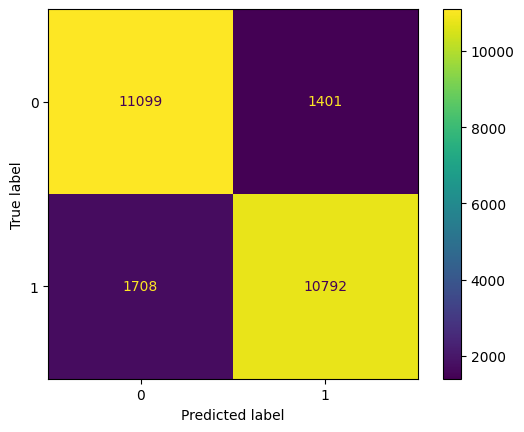

In [ ]:

# Here to get a Max Accuracy we will use Pipeline and GridsearchCV to get the Best Parameters for Our SVM model
# now i will use TfidfVectorizer to converts the reviews string in Vectors
models={"SVM":{"model":Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("svm",LinearSVC(max_iter=10000))
    ]),
      "param":{
          "tfidf__max_features":[30000,50000],
          "tfidf__ngram_range":[(1,1),(1,2)], # this is used for understanding the phrase
          "tfidf__min_df":[3,5],# ignore words that apears in very less amount
          "tfidf__max_df":[0.7,0.8,0.9], # ignores the words that appears in Whole Dataset by these percentage
          "tfidf__stop_words":['english'],
          "svm__C":[0.1,1,10,100]
      }
    }
  }
# Train And Evaluate
results={}
for name,config in models.items():
  print(f"\n--- Training {name}---")
  #Grid search With Cross validation
  grid_search=GridSearchCV(
      estimator=config['model'],
      param_grid=config['param'],
      cv=5,
      scoring='accuracy',
      n_jobs=-1)
  # Fit the Model
  grid_search.fit(X_train,y_train)

  # Model Predidction
  best_model=grid_search.best_estimator_
  y_pred=best_model.predict(X_test)
  #Calculate metrices
  Accuracy = accuracy_score(y_test,y_pred)


  results[name]={
      'model':best_model,
      'y_pred': y_pred,
      'accuracy':Accuracy,
      'best_params':grid_search.best_params_

  }
  print(f"Best parameters: {grid_search.best_params_}")
  print(f"Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}%")
  print("Classification Report:")
  print(classification_report(y_test,y_pred))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

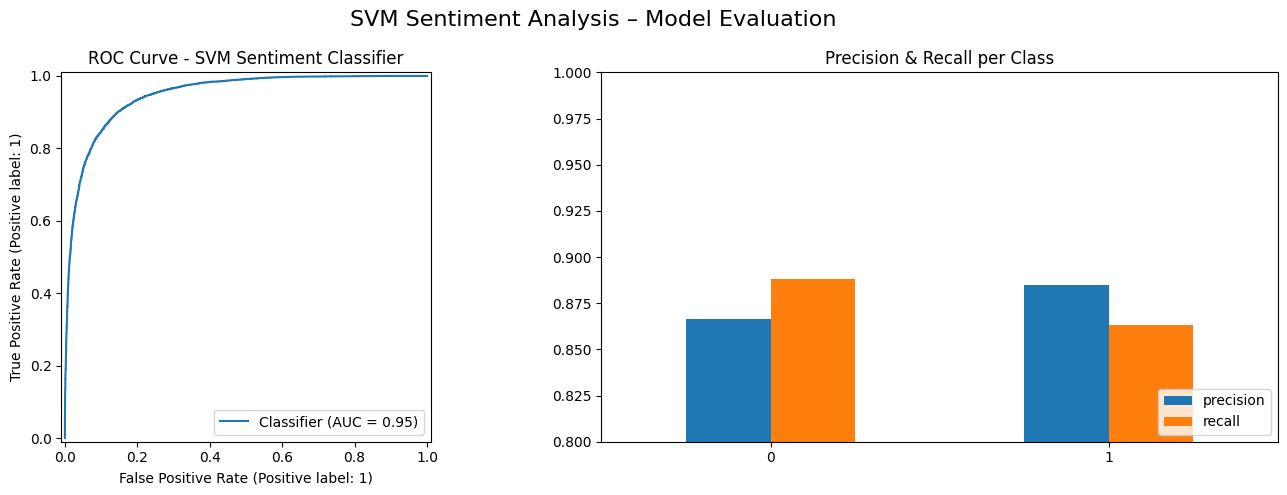

In [ ]:
#Plots for the Trainig Results
fig, axes=plt.subplots(1, 2, figsize=(14, 5))
y_scores=best_model.decision_function(X_test)
RocCurveDisplay.from_predictions(
    y_test,
    y_scores,
    ax=axes[0]
)
axes[0].set_title("ROC Curve - SVM Sentiment Classifier")
report=classification_report(y_test, y_pred, output_dict=True)
df=pd.DataFrame(report).transpose()

df.loc[["0", "1"], ["precision", "recall"]].plot(
    kind="bar",
    ax=axes[1],
    rot=0
)
axes[1].set_title("Precision & Recall per Class")
axes[1].set_ylim(0.8, 1.0)
axes[1].legend(loc="lower right")
plt.suptitle("SVM Sentiment Analysis - Model Evaluation", fontsize=16)
plt.tight_layout()
plt.show()
